In [56]:
import numpy as np
import pandas as pd

from scipy import stats
from pylab import plt, mpl


from sklearn import svm
from sklearn.metrics import classification_report

In [40]:
raw = pd.read_csv('usd.csv', parse_dates=True)

#### transform the date to datetime format
raw['Date'] = pd.to_datetime(raw['Date'])
raw.set_index('Date', inplace=True)
print(raw.head())

            DEXUSEU
Date               
2018-05-07   1.1927
2018-05-08   1.1863
2018-05-09   1.1852
2018-05-10   1.1896
2018-05-11   1.1951


In [41]:
freq = '1D'
data = raw.resample(freq, label='right').last().ffill()
print(data.head())

            DEXUSEU
Date               
2018-05-08   1.1927
2018-05-09   1.1863
2018-05-10   1.1852
2018-05-11   1.1896
2018-05-12   1.1951


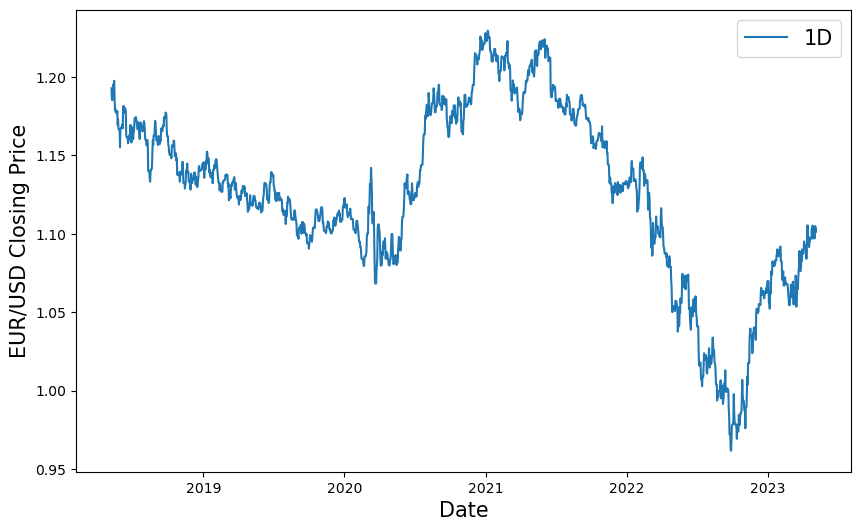

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(data.index), data['DEXUSEU'], '-')
plt.xlabel('Date', fontsize=15)
plt.ylabel('EUR/USD Closing Price', fontsize=15)
plt.legend([freq], fontsize=15)

In [44]:
close = data['DEXUSEU']
Y1=np.log( close/close.shift(1) )
Y1

Date
2018-05-08         NaN
2018-05-09   -0.005380
2018-05-10   -0.000928
2018-05-11    0.003706
2018-05-12    0.004613
                ...   
2023-05-02   -0.006361
2023-05-03    0.002458
2023-05-04    0.004717
2023-05-05   -0.003627
2023-05-06    0.001543
Freq: D, Name: DEXUSEU, Length: 1825, dtype: float64

In [45]:
Y2=(Y1>0).astype(int)
Y2

Date
2018-05-08    0
2018-05-09    0
2018-05-10    0
2018-05-11    1
2018-05-12    1
             ..
2023-05-02    0
2023-05-03    1
2023-05-04    1
2023-05-05    0
2023-05-06    1
Freq: D, Name: DEXUSEU, Length: 1825, dtype: int32

In [46]:
temp1=close[1:].reset_index(drop=True)
temp2=close[0:-1].reset_index(drop=True)
Y1_b=np.log(temp1/temp2)
Y1_b


0      -0.005380
1      -0.000928
2       0.003706
3       0.004613
4       0.000000
          ...   
1819   -0.006361
1820    0.002458
1821    0.004717
1822   -0.003627
1823    0.001543
Name: DEXUSEU, Length: 1824, dtype: float64

In [47]:
Y1_1=Y1.copy()

In [48]:
Y1_2=Y1_1.shift(1)
Y1_3=Y1_1.shift(2)

Y1_3day=pd.concat([Y1_1,Y1_2,Y1_3],axis=1)

Y1_3day.head()

,DEXUSEU,DEXUSEU,DEXUSEU
Date,,,
2018-05-08,NaN,NaN,NaN
2018-05-09,-0.005380,NaN,NaN
2018-05-10,-0.000928,-0.005380,NaN
2018-05-11,0.003706,-0.000928,-0.005380
2018-05-12,0.004613,0.003706,-0.000928


In [49]:
Y1_3day.columns = ['1 day lag','2 day lag ','3 day lag']
Y1_3day.head()

,1 day lag,2 day lag,3 day lag
Date,,,
2018-05-08,NaN,NaN,NaN
2018-05-09,-0.005380,NaN,NaN
2018-05-10,-0.000928,-0.005380,NaN
2018-05-11,0.003706,-0.000928,-0.005380
2018-05-12,0.004613,0.003706,-0.000928


In [50]:
X=Y1_3day[3:-1]
Y=Y2[4:]

In [51]:
temp=pd.concat([X,Y],axis=1)
temp


,1 day lag,2 day lag,3 day lag,DEXUSEU
Date,,,,
2018-05-11,0.003706,-0.000928,-0.005380,NaN
2018-05-12,0.004613,0.003706,-0.000928,1.0
2018-05-13,0.000000,0.004613,0.003706,0.0
2018-05-14,0.000000,0.000000,0.004613,0.0
2018-05-15,0.002090,0.000000,0.000000,1.0
...,...,...,...,...
2023-05-02,-0.006361,0.000000,0.000000,0.0
2023-05-03,0.002458,-0.006361,0.000000,1.0
2023-05-04,0.004717,0.002458,-0.006361,1.0


In [52]:
X=Y1_3day[3:-1].reset_index(drop=True)

Y=Y2[4:].reset_index(drop=True)
temp=pd.concat([X,Y],axis=1)
temp

,1 day lag,2 day lag,3 day lag,DEXUSEU
0,0.003706,-0.000928,-0.005380,1
1,0.004613,0.003706,-0.000928,0
2,0.000000,0.004613,0.003706,0
3,0.000000,0.000000,0.004613,1
4,0.002090,0.000000,0.000000,0
...,...,...,...,...
1816,0.000000,0.000000,0.002086,0
1817,-0.006361,0.000000,0.000000,1
1818,0.002458,-0.006361,0.000000,1
1819,0.004717,0.002458,-0.006361,0


In [53]:
split_ratio = 0.7
split_loc = int(split_ratio* X.shape[0])
split_loc

1274

In [54]:
X_train=X[0:split_loc]
Y_train=Y[0:split_loc].astype(float)


X_test=X[split_loc:]
Y_test=Y[split_loc:].astype(float)

In [59]:
# import the LR model
from sklearn.linear_model import LogisticRegression

# define the LR model
skl_model = LogisticRegression()
LR_model = LogisticRegression()
LR_model.fit(X_train,Y_train)
pred1 = LR_model.predict(X_test)

In [60]:
report1 = classification_report(pred1,Y_test)
print(report1)

              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80       547
         1.0       0.00      0.00      0.00         0

    accuracy                           0.67       547
   macro avg       0.50      0.33      0.40       547
weighted avg       1.00      0.67      0.80       547



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
# import tree
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='gini',
                                      max_depth=4, min_samples_leaf=10,
                                      min_samples_split=4)
clf.fit(X_train,Y_train)
pred2 = clf.predict(X_test)

In [64]:
report2 = classification_report(pred2,Y_test)
print(report2)

              precision    recall  f1-score   support

         0.0       0.90      0.69      0.78       478
         1.0       0.18      0.46      0.26        69

    accuracy                           0.66       547
   macro avg       0.54      0.58      0.52       547
weighted avg       0.81      0.66      0.71       547



In [65]:
Y_train.value_counts()

0.0    843
1.0    431
Name: DEXUSEU, dtype: int64